## Customer Segmentation (TravelTide)

Goal: Segment customers into interpretable groups and evaluate evidence for Elena’s proposed perks using behavioral data.


In [39]:
# 0) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


## 1. Load Preprocessed Data
We load the preprocessed session-level dataset and prepare it for user-level aggregation and segmentation.


In [40]:
df = pd.read_csv("../data/traveltide_preprocessed.csv")
df.head()


,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,...,destination_airport_lon,base_fare_usd,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,session_duration,booking_lead_time_days
0,474007-040d8694832845e98a710bfc20194f52,474007,NaN,2023-03-28 21:35:00,2023-03-28 21:35:24,3,False,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN
1,491175-456ae210ac9c4150800565740316dc77,491175,NaN,2023-03-28 19:14:00,2023-03-28 19:15:16,10,False,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,NaN
2,520603-67823ebddae848398ce155649a426242,520603,NaN,2023-03-28 16:38:00,2023-03-28 16:38:45,6,False,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN
3,524180-e1e5d53c38114c8bbd236d9f603546ca,524180,NaN,2023-03-28 18:56:00,2023-03-28 18:57:38,13,False,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,NaN
4,527801-5fe15cbf9fee42d5b2c9e76aeef603a1,527801,NaN,2023-03-28 20:03:00,2023-03-28 20:03:29,4,False,NaN,True,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,NaN


## 2. User-Level Feature Engineering
Session-level data is aggregated to the user level so that each row represents one user.
The features capture engagement, planning behavior, spending, and booking reliability.


In [41]:
user_df = df.groupby("user_id").agg(
    num_sessions=("session_id", "count"),
    avg_session_duration=("session_duration", "mean"),
    avg_booking_lead_time=("booking_lead_time_days", "mean"),
    avg_base_fare=("base_fare_usd", "mean"),
    hotel_booking_rate=("hotel_booked", "mean"),
    cancellation_rate=("cancellation", "mean"),
    # OPTIONAL (only if you want 1 extra signal for "hesitant" behavior):
    avg_page_clicks=("page_clicks", "mean") if "page_clicks" in df.columns else ("session_id", "count")
).reset_index()

user_df.head()


,user_id,num_sessions,avg_session_duration,avg_booking_lead_time,avg_base_fare,hotel_booking_rate,cancellation_rate,avg_page_clicks
0,23557,8,76.625000,NaN,NaN,0.250,0.000,10.250
1,94883,8,67.750000,6.5,432.045,0.250,0.000,9.125
2,101486,8,122.250000,9.0,189.910,0.250,0.000,16.375
3,101961,8,117.750000,5.6,248.532,0.625,0.000,15.750
4,106907,8,169.285714,198.5,13902.060,0.250,0.125,30.000


## 3. Feature Selection for Clustering
We use numerical/behavioral features only (no categorical encoding required).


In [42]:
features = [
    "num_sessions",
    "avg_session_duration",
    "avg_booking_lead_time",
    "avg_base_fare",
    "hotel_booking_rate",
    "cancellation_rate",
]

# If you added avg_page_clicks above and want to use it, uncomment:
# features.append("avg_page_clicks")

X = user_df[features].fillna(0)
X.describe()


,num_sessions,avg_session_duration,avg_booking_lead_time,avg_base_fare,hotel_booking_rate,cancellation_rate
count,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000
mean,8.204568,170.621934,17.231010,463.685169,0.303488,0.012358
std,0.460911,221.175559,43.329997,697.382592,0.182894,0.037757
min,8.000000,31.500000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,92.500000,5.333333,211.285000,0.125000,0.000000
50%,8.000000,115.645833,6.750000,356.460000,0.250000,0.000000
75%,8.000000,145.218750,8.000000,525.329375,0.375000,0.000000
max,12.000000,2137.625000,365.000000,14280.380000,1.000000,0.250000


## 4. Scaling
KMeans is distance-based, so we standardize all features.


In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 5. Choosing the Number of Clusters (k)
We evaluate different values of k using:
- Elbow method (inertia)
- Silhouette score

We select k=4 as a balance between cluster quality and interpretability.


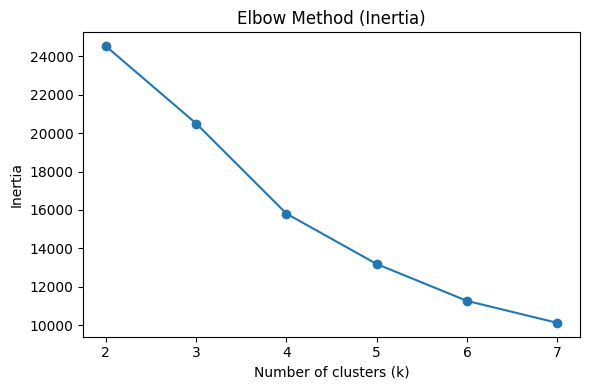

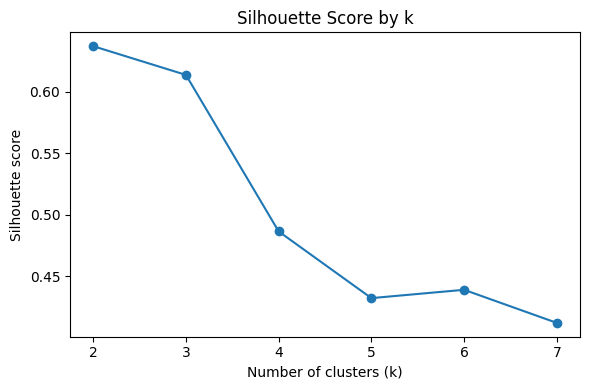

,k,inertia,silhouette
0,2,24524.346108,0.637188
1,3,20499.604500,0.613801
2,4,15808.001822,0.486440
3,5,13185.353083,0.432155
4,6,11268.032815,0.438923
5,7,10124.438369,0.411999


In [44]:
ks = range(2, 8)

# Elbow (inertia)
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(ks), inertias, marker="o")
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

# Silhouette
sil_scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(list(ks), sil_scores, marker="o")
plt.title("Silhouette Score by k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.tight_layout()
plt.show()

pd.DataFrame({"k": list(ks), "inertia": inertias, "silhouette": sil_scores})


## 6. KMeans Clustering (k = 4)
KMeans produces numeric labels (0–3). These labels are interpreted and named after reviewing cluster profiles.


In [45]:
kmeans = KMeans(n_clusters=4, random_state=42)
user_df["cluster"] = kmeans.fit_predict(X_scaled)

user_df["cluster"].value_counts().sort_index()


cluster
0     242
1    4370
2     407
3     979
Name: count, dtype: int64

### 6.1 Cluster size distribution (rollout/cost context)
This shows how many users would receive perks if targeted by cluster.


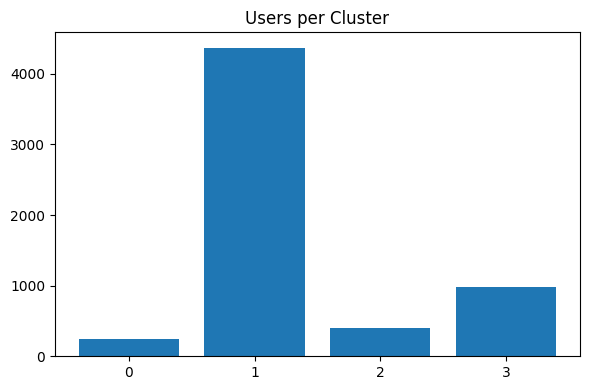

In [46]:
counts = user_df["cluster"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Users per Cluster")
plt.tight_layout()
plt.show()


## 7. Cluster Profiling (what defines each cluster?)
We compute average feature values per cluster. This table is your main “evidence” object for personas and perks.


In [47]:
cluster_profile = user_df.groupby("cluster")[features].mean().sort_index()
cluster_profile


,num_sessions,avg_session_duration,avg_booking_lead_time,avg_base_fare,hotel_booking_rate,cancellation_rate
cluster,,,,,,
0,8.181818,364.116575,192.098829,2484.213218,0.228134,0.078535
1,8.000000,115.875208,8.872081,426.168874,0.296138,0.000029
2,8.199017,772.152800,39.132648,579.321400,0.481205,0.126703
3,9.125638,117.092236,10.147604,443.968329,0.281041,0.003500


### 7.1 Cluster profile heatmap (slide-friendly overview)
Standardized means (z-scores) help compare features on one scale.


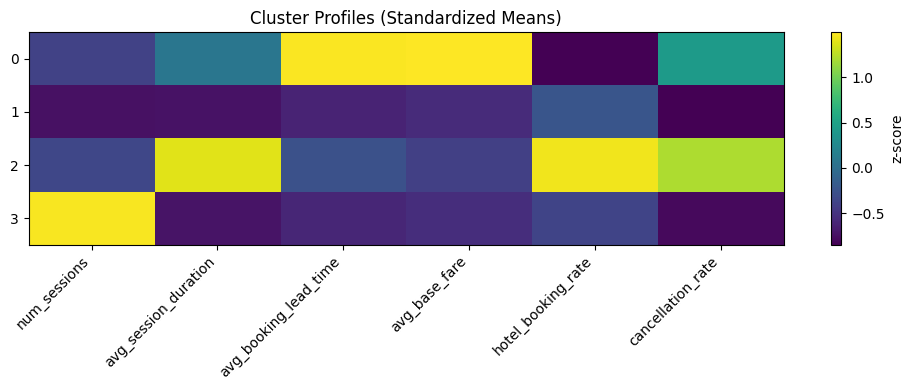

In [48]:
profile_z = (cluster_profile - cluster_profile.mean()) / cluster_profile.std()

plt.figure(figsize=(10,4))
plt.imshow(profile_z.values, aspect="auto")
plt.xticks(range(len(profile_z.columns)), profile_z.columns, rotation=45, ha="right")
plt.yticks(range(len(profile_z.index)), profile_z.index)
plt.title("Cluster Profiles (Standardized Means)")
plt.colorbar(label="z-score")
plt.tight_layout()
plt.show()


## 8. Assign Descriptive Cluster Names (interpretation)
Cluster labels are arbitrary. After reviewing the profile table above, we assign descriptive names.

IMPORTANT:
If your cluster meanings differ, update the mapping accordingly.


In [49]:
# START with placeholder names. Update after reading cluster_profile.
cluster_names = {
    0: "Cluster A",
    1: "Cluster B",
    2: "Cluster C",
    3: "Cluster D"
}

user_df["cluster_name"] = user_df["cluster"].map(cluster_names)

# Quick check
user_df[["user_id", "cluster", "cluster_name"]].head()


,user_id,cluster,cluster_name
0,23557,1,Cluster B
1,94883,1,Cluster B
2,101486,1,Cluster B
3,101961,1,Cluster B
4,106907,0,Cluster A


### Rename clusters to business personas


In [50]:
cluster_names = {0: "Frequent Planners", 1: "Price-Sensitive Explorers", 2: "Hesitant Explorers", 3: "High-Value Travelers"}
user_df["cluster_name"] = user_df["cluster"].map(cluster_names)


## 9. Evidence Visuals for Elena’s Perks
We visualize behavior signals that relate to perk ideas. These charts support partial/full validation and targeting.

Perks:
1) Free hotel meal
2) Free checked bag
3) No cancellation fees
4) Exclusive discounts
5) 1 free hotel night with flight


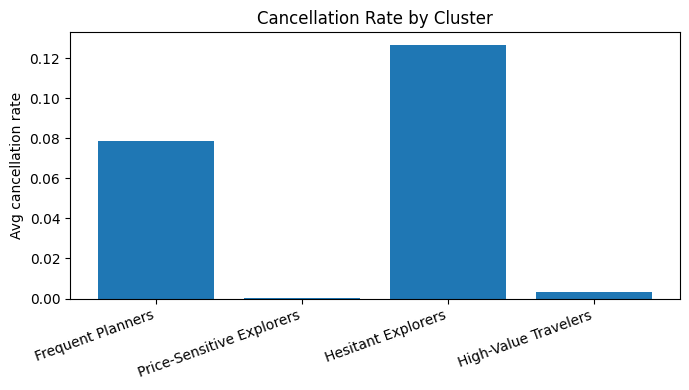

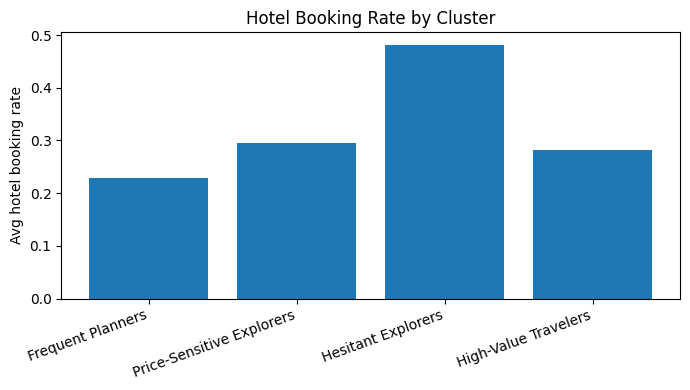

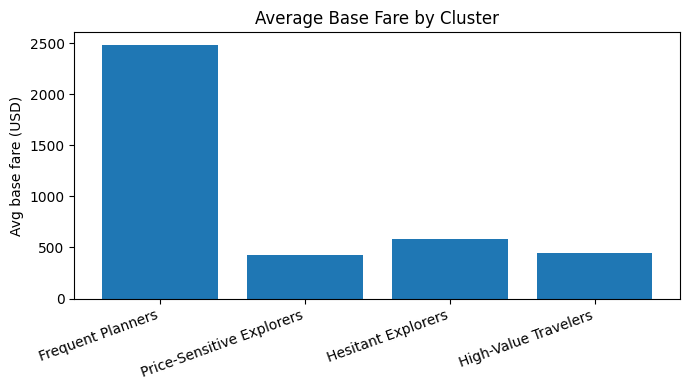

In [51]:
# Helper: mean by cluster name in a fixed order
order = list(cluster_names.values())
def mean_by_cluster(metric):
    return user_df.groupby("cluster_name")[metric].mean().reindex(order)

# 9.1 No cancellation fees -> cancellation_rate
vals = mean_by_cluster("cancellation_rate")
plt.figure(figsize=(7,4))
plt.bar(vals.index, vals.values)
plt.title("Cancellation Rate by Cluster")
plt.ylabel("Avg cancellation rate")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# 9.2 Free hotel meal / free hotel night -> hotel_booking_rate
vals = mean_by_cluster("hotel_booking_rate")
plt.figure(figsize=(7,4))
plt.bar(vals.index, vals.values)
plt.title("Hotel Booking Rate by Cluster")
plt.ylabel("Avg hotel booking rate")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# 9.3 Exclusive discounts -> avg_base_fare (proxy for price tier)
vals = mean_by_cluster("avg_base_fare")
plt.figure(figsize=(7,4))
plt.bar(vals.index, vals.values)
plt.title("Average Base Fare by Cluster")
plt.ylabel("Avg base fare (USD)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


## 10. Export Results (cluster assignment)
We export the final user-level dataset with cluster assignment. This is a required artifact for many segmentation projects.


In [52]:
user_df.to_csv(../data/"user_segments.csv", index=False)
user_df.head()


SyntaxError: invalid syntax (312925508.py, line 1)

In [ ]:
# Assign one primary perk per cluster (rule-based mapping)
perk_mapping = {
    "Hesitant Explorers": "No cancellation fees",
    "Price-Sensitive Explorers": "Exclusive discounts",
    "Frequent Planners": "Free checked bag",
    "High-Value Travelers": "Free hotel meal"
}

user_df["assigned_perk"] = user_df["cluster_name"].map(perk_mapping)

# Create final perks CSV
user_perks = user_df[["user_id", "cluster_name", "assigned_perk"]]

user_perks.to_csv("../data/user_perks.csv", index=False)

user_perks.head()


,user_id,cluster_name,assigned_perk
0,23557,Price-Sensitive Explorers,Exclusive discounts
1,94883,Price-Sensitive Explorers,Exclusive discounts
2,101486,Price-Sensitive Explorers,Exclusive discounts
3,101961,Price-Sensitive Explorers,Exclusive discounts
4,106907,Frequent Planners,Free checked bag


## 11) Summary (for presentation)
- We aggregated sessions to users and created behavioral features.
- We evaluated k using elbow + silhouette and selected k=4 for interpretability and quality.
- We profiled clusters and used targeted visuals to support (full/partial) validation of Elena’s perk ideas.
- We exported user-level cluster assignments for activation and further analysis.
